# Определение перспективного тарифа для телеком-компании

## Исходные данные

### Описание проекта

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

*Тариф «Смарт»*

- Ежемесячная плата: 550 рублей

- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

*Тариф «Ультра»*

- Ежемесячная плата: 1950 рублей

- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

Таблица `users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана

Таблица `calls` (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Общая информация о данных и их предобработка

Установка библиотек:

In [ ]:
!pip install seaborn -U

Импорт библиотек:

In [7]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats as st

Прочитаем файлы с датасетами и сохраним их в соотвествующие датафреймы:

In [2]:
users = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\users.csv')
calls = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\calls.csv')
messages = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\messages.csv')
internet = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\internet.csv')
tariffs = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\tariffs.csv')

Посмотрим общую информацию о каждом датафрейме и ознакомимся со значениями в столбцах таблиц с помощью функции:

In [26]:
def dataframe_info(df):
    columns = df.columns
    print('Первые пять строк:')
    display(df.head())
    print('Основная информация о датафрейме:')
    df.info()
    print('Доля пропусков в датафрейме:')
    display(df.isna().mean())
    print('Число явных дубликатов: ', df.duplicated().sum())
    print('Основные статистические характеристики датафрейма:')
    display(df.describe().T)
    print('Уникальные значения в столбцах:')
    for column in columns:
        display(df[column].value_counts())

### Датафрейм: users

Посмотрим информацию о датарфейме с помощью функции:

In [27]:
dataframe_info(users)

Первые пять строк:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
Доля пропусков в датафрейме:


user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

Число явных дубликатов:  0
Основные статистические характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


Уникальные значения в столбцах:


1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: user_id, Length: 500, dtype: int64

53    14
42    14
63    13
64    13
71    13
73    12
21    12
40    12
37    11
29    11
39    11
26    11
47    11
70    10
45    10
41    10
52    10
58    10
36    10
66     9
23     9
50     9
65     9
19     9
48     9
24     9
68     9
27     9
28     9
51     9
20     9
56     9
30     9
60     8
44     8
69     8
62     8
55     8
74     7
25     7
46     7
35     7
32     7
67     7
43     7
31     7
18     6
75     6
54     6
59     6
72     5
22     5
34     5
33     5
38     5
49     4
57     4
61     3
Name: age, dtype: int64

2018-12-03    2
2018-10-03    2
2018-10-14    2
2018-12-09    2
2018-12-21    2
2018-12-30    1
2018-10-28    1
2018-11-26    1
2018-11-27    1
2018-11-16    1
2018-10-27    1
2018-10-05    1
2018-09-27    1
2018-11-13    1
2018-12-25    1
2018-12-14    1
2018-12-24    1
2018-09-26    1
2018-11-22    1
2018-08-17    1
2018-10-04    1
2018-09-02    1
2018-12-18    1
2018-11-30    1
2018-12-20    1
2018-12-16    1
2018-11-07    1
2018-12-23    1
2018-08-31    1
2018-12-26    1
2018-12-11    1
2018-11-21    1
2018-10-25    1
Name: churn_date, dtype: int64

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Иваново             1
Нижневартовск       1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

Радим      6
Леонид     5
Пётр       5
Андрей     4
Адам       4
          ..
Зинаида    1
Глеб       1
Роза       1
Юзефа      1
Трифон     1
Name: first_name, Length: 246, dtype: int64

Андреенко     5
Березина      3
Аркадьев      3
Булгаков      3
Соловьев      3
             ..
Медведев      1
Минаева       1
Авдонюшкин    1
Андрейчук     1
Акимчин       1
Name: last_name, Length: 419, dtype: int64

2018-05-28    8
2018-11-16    5
2018-10-05    5
2018-04-03    5
2018-01-04    5
             ..
2018-09-20    1
2018-04-28    1
2018-08-07    1
2018-06-18    1
2018-04-25    1
Name: reg_date, Length: 270, dtype: int64

smart    351
ultra    149
Name: tariff, dtype: int64

Названия столбцов унифицированы. Нужно привести столбцы `churn_date` и `reg_date` к типу хранения даты и времени - *datetime*. Сразу бросаются в глаза явные пропуски (92.4%) в столбце `churn_date`. Заполнять их не требуется, так как в исходных данных указано, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

Дубликатов не выявлено. Значения в столбцах выглядят нормально, никаких аномалий не обнаружено. Все *id* пользователей уникальны. Значения в столбце с городом также выглядят унифицировано, видимо при заполнении имеет место не произвольный ввод а выбор из представленных вариантов.

Перезапишем датафрейм `users` указав параметр *parse_dates* при чтении файла *csv* чтобы сразу перевести столбцы `churn_date` и `reg_date` к формату *datetime*:

In [5]:
users = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\users.csv', parse_dates=['churn_date', 'reg_date'])

Проверим изменение типа данных столбцов:

In [6]:
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

### Вывод. Датафрейм: users

- Тип данных в столбцах `churn_date` и `reg_date` был приведен к типу хранения даты и времени *datetime*. 
- Никаких аномалий в значениях столбцов не обнаружено. 
- Дубликатов не выявлено.
- Датафрейм готов к дальнейшему исследованию.
    

### Датафрейм: calls

Посмотрим информацию о датарфейме с помощью функции:

In [28]:
dataframe_info(calls)

Первые пять строк:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
Доля пропусков в датафрейме:


id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64

Число явных дубликатов:  0
Основные статистические характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


Уникальные значения в столбцах:


1000_0      1
1344_881    1
1344_883    1
1344_884    1
1344_885    1
           ..
1171_562    1
1171_563    1
1171_564    1
1171_565    1
1499_219    1
Name: id, Length: 202607, dtype: int64

2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
26.94        1
32.19        1
26.32        1
27.41        1
26.90        1
Name: duration, Length: 2871, dtype: int64

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

Названия столбцов унифицированы, однако, название столбца `id` не информативно. Переименуем его в `call_id`. Столбец `call_date` необходимо привести к типу *datetime*. Явных пропусков данных нет, дубликатов не выявлено.

В столбце `duration` имеется много звонков с нулевой продолжительностью, значения в остальных столбцах выглядят нормально, никаких аномалий больше не обнаружено. Посчитаем долю звонков с нулевой продолжительностью:

In [49]:
calls.query('duration == 0')['duration'].count() / calls.shape[0]

0.19551644316336553

19.5% звонков с нулевой продолжительностью. Нулевая продолжительность звонков означает что звонок был пропущен, такие пропуски заполнять не нужно.

Перезапишем датафрейм `calls` чтобы сразу перевести столбец `call_date` к формату *datetime*:

In [29]:
calls = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\calls.csv', parse_dates=['call_date'])

Переименуем столбец методом *rename*:

In [30]:
calls.rename(columns={'id' : 'call_id'}, inplace=True)

Проверим изменение типа данных и названия столбцов:

In [31]:
calls.dtypes

call_id              object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

### Вывод. Датафрейм: calls

- Название столбца `id` изменено на более информативное - `call_id`.
- Тип данных в столбцах `call_date` был приведен к типу хранения даты и времени *datetime*. 
- В столбце с продолжительностью звонка (`duration`) 20 % значений с нулевой продолжительностью звонка, такие пропуски заполнять не нужно. Никаких аномалий в других значениях не обнаружено. 
- Дубликатов не выявлено.
- Датафрейм готов к дальнейшему исследованию.

### Датафрейм: messages

Посмотрим информацию о датарфейме с помощью функции:

In [33]:
dataframe_info(messages)

Первые пять строк:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Доля пропусков в датафрейме:


id              0.0
message_date    0.0
user_id         0.0
dtype: float64

Число явных дубликатов:  0
Основные статистические характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


Уникальные значения в столбцах:


1000_0      1
1344_248    1
1344_96     1
1344_95     1
1344_94     1
           ..
1174_352    1
1174_351    1
1174_350    1
1174_349    1
1499_183    1
Name: id, Length: 123036, dtype: int64

2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-28    699
             ... 
2018-01-11     12
2018-01-05     10
2018-01-04     10
2018-01-02     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

Названия столбцов унифицированы, однако, название столбца `id` не информативно. Переименуем его в `message_id`. Столбец `message_date` нужно привести к типу *datetime*. Пропусков данных нет, дубликатов не выявлено.

Значения в столбцах выглядят нормально, никаких аномалий не обнаружено.

Перезапишем датафрейм `messages` чтобы сразу перевести столбец `message_date` к формату *datetime*:

In [34]:
messages = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\messages.csv', parse_dates=['message_date'])

Переименуем столбец методом *rename*:

In [35]:
messages.rename(columns={'id' : 'message_id'}, inplace=True)

Проверим изменение типа данных и названия столбцов:

In [36]:
messages.dtypes

message_id              object
message_date    datetime64[ns]
user_id                  int64
dtype: object

### Вывод. Датафрейм: messages

- Название столбца `id` изменено на более информативное - `message_id`.
- Тип данных в столбце `message_date` был приведен к типу хранения даты и времени *datetime*. 
- Никаких аномалий в значениях не обнаружено. 
- Дубликатов не выявлено.
- Датафрейм готов к дальнейшему исследованию.

### Датафрейм: internet

Посмотрим информацию о датарфейме с помощью функции:

In [37]:
dataframe_info(internet)

Первые пять строк:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
Доля пропусков в датафрейме:


Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64

Число явных дубликатов:  0
Основные статистические характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


Уникальные значения в столбцах:


0         1
99574     1
99594     1
99595     1
99596     1
         ..
49798     1
49799     1
49800     1
49801     1
149395    1
Name: Unnamed: 0, Length: 149396, dtype: int64

1000_0      1
1333_109    1
1334_0      1
1334_1      1
1334_2      1
           ..
1172_80     1
1172_81     1
1172_82     1
1172_83     1
1499_156    1
Name: id, Length: 149396, dtype: int64

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64

2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-02       3
2018-01-01       3
Name: session_date, Length: 365, dtype: int64

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

Столбец `Unnamed: 0` дублирует индекс датафрейма, нужно от него избавится. Названия столбцов унифицированы, однако, название столбца `id` не информативно - переименуем его в `internet_session_id`. Столбец `session_date` нужно привести к типу *datetime*. Пропусков данных нет, дубликатов не выявлено.

В столбце *mb_used* много пропущенных значений соответствующих 0 Мб израсходованного трафика. Выглядит странно, посчитаем долю таких значений в датафрейме:

In [64]:
internet.query('mb_used == 0')['mb_used'].count() / internet.shape[0]

0.13118155773916304

13.1% пропусков, довольно весомое число. Попробуем разобраться с причиной пропущенного интернет-трафика после изменения типа данных столбца с датой и удаления столбца-индекса.

Перезапишем датафрейм `internet` чтобы сразу перевести столбец `session_date` к формату *datetime*, также задав параметр *index_col=0* избавимся от столбца с индексом `Unnamed: 0`:

In [38]:
internet = pd.read_csv(r'C:\Users\IVMitrofanov\Downloads\internet.csv', parse_dates=['session_date'], index_col=0)

Переименуем столбец методом *rename*:

In [39]:
internet.rename(columns={'id' : 'internet_session_id'}, inplace=True)

Проверим изменение типа данных и названия столбцов:

In [40]:
internet.dtypes

internet_session_id            object
mb_used                       float64
session_date           datetime64[ns]
user_id                         int64
dtype: object

Построим распределение доли (параметр *stat='propability'*) интернет сессий с нулевым (красный цвет на гистограмме) и не нулевым (синий цвет на гистограмме) интернет-трафиком от даты интернет-сессии:

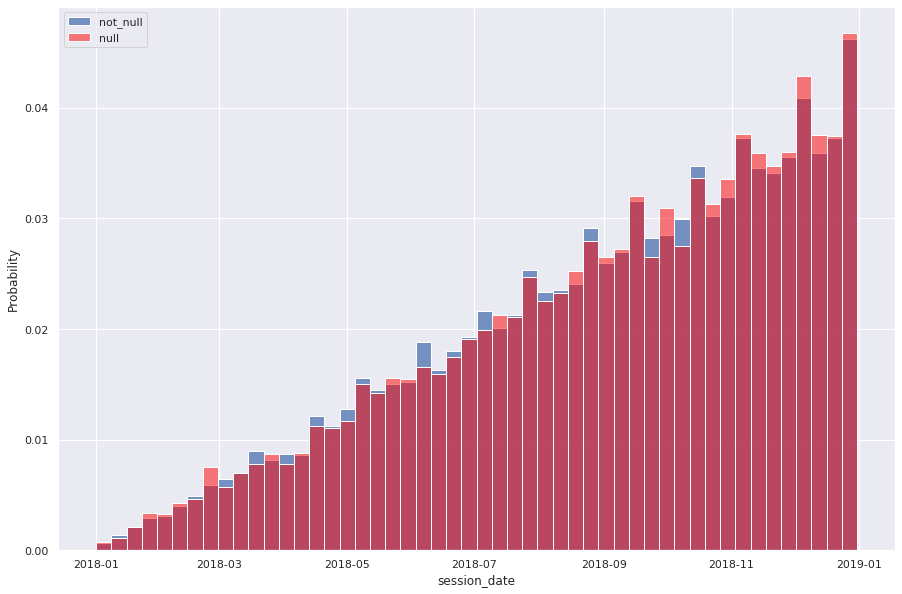

In [212]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 10))
ax = sns.histplot(internet.query(
                 'mb_used != 0')['session_date'], 
                  bins=50, 
                  stat='probability', 
                  label='not_null')
sns.histplot(internet.query(
            'mb_used == 0')['session_date'], 
             ax=ax, 
             bins=50, 
             stat='probability', 
             alpha=0.5, 
             color='red',
             label='null')
plt.legend()
plt.show()

Распределения практически полностью совпадают, это говорит о том, что нулевой трафик присутствует в данных пропорционально числу интернет-сессий. Это не похоже на сбой данных. 

Возможно нулевой расход интернет трафика связан с тем, что при загрузке и использовании приложений возможны служебные DNS-запросы, которые выполняются автоматически для определения соответствия доменного имени и IP-адреса, такие запросы не превышают 10 Кбайт. Такие пропуски заполнять не будем, считая, что пользователь к этой записе в датасете отношения не имеет

### Вывод. Датафрейм: internet


- Название столбца `id` изменено на более информативное - `internet_session_id`.
- Тип данных в столбце `session_date` был приведен к типу хранения даты и времени *datetime*. 
- В столбце с расходом интернет-трафика (`mb_used`) 13 % значений с нулевым расходом интернет-трафика. Скорее всего эти нули появляются из-за служебных запоросов приложений не связанных с реальной активностью клиента. Такие пропуски мы заполнять не будем.
- Дубликатов не выявлено.
- Датафрейм готов к работе.

### Датафрейм: tariffs

Посмотрим информацию о датарфейме с помощью функции:

In [42]:
dataframe_info(tariffs)

Первые пять строк:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
Доля пропусков в датафрейме:


messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64

Число явных дубликатов:  0
Основные статистические характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


Уникальные значения в столбцах:


50      1
1000    1
Name: messages_included, dtype: int64

15360    1
30720    1
Name: mb_per_month_included, dtype: int64

500     1
3000    1
Name: minutes_included, dtype: int64

550     1
1950    1
Name: rub_monthly_fee, dtype: int64

200    1
150    1
Name: rub_per_gb, dtype: int64

3    1
1    1
Name: rub_per_message, dtype: int64

3    1
1    1
Name: rub_per_minute, dtype: int64

smart    1
ultra    1
Name: tariff_name, dtype: int64

Данный датафрейм содержит всего 2 строки и несет в себе лишь информацию о тарифах. В столбце `mb_per_month_included` значения нужно перевести в Гб с соотвествущей заменой названия столбца. Никаих других операций предобработки данных датафрейм не требует.

Переведем Мб из столбца `mb_per_month_included` в Гб и перименуем столбец соответствующее:

In [43]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

In [44]:
tariffs.rename(columns={'mb_per_month_included' : 'gb_per_month_included'}, inplace=True)

Проверим результат:

In [45]:
tariffs['gb_per_month_included'].head()

0    15.0
1    30.0
Name: gb_per_month_included, dtype: float64

### Вывод. Датафрейм: tariffs

- Датафрейм содержит информацию об условиях тарификации клиентов.
- Столбец `mb_per_month_included` переведен в Гб и переименовать в `gb_per_month_included`.
- Датафрейм готов к дальнейшему исследованию.

## Необходимые расчеты

Для каждого пользователя необходимо посчитать:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Расчеты будем записывать в датафрейм `calc`.

In [46]:
calc = pd.DataFrame()

### Расчет количества сделанных звонков и израсходованных минут разговора по месяцам

Выведем первые 5 строк датафрейма `calls`:

In [48]:
calls.head()

,call_id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Для расчета по месяцам округлим дату каждого звонка до месяца и запишем этот месяц в столбец `month_of_call`:

In [49]:
calls['month'] = calls['call_date'].dt.month

Расчитаем количество сделанных звонков:

In [50]:
number_of_calls = calls.pivot_table(index=['user_id', 'month'], values='call_id', aggfunc='count')
number_of_calls.columns = ['number_of_calls']

In [51]:
number_of_calls

number_of_calls
user_id month                 
1000    5                   22
        6                   43
        7                   47
        8                   52
        9                   58
...                        ...
1498    10                  41
1499    9                    9
        10                  68
        11                  74
        12                  69

[3174 rows x 1 columns]

Прежде чем считать израсходованные минуты, учтем, что «Мегалайн» всегда округляет секунды до минут для каждого звонка. После округления изменим тип данных в столбце `duration` на *int*.

In [52]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype(int)

Вычислим израсходованные минуты разговора по месяцам:

In [53]:
spent_minutes_on_month = calls.pivot_table(
    index=['user_id', 'month'],
    values='duration',
    aggfunc='sum')
spent_minutes_on_month['duration'] = spent_minutes_on_month['duration']

Объеденим расчеты:

In [54]:
calc = number_of_calls.join(spent_minutes_on_month)
calc

number_of_calls  duration
user_id month                           
1000    5                   22       159
        6                   43       172
        7                   47       340
        8                   52       408
        9                   58       466
...                        ...       ...
1498    10                  41       247
1499    9                    9        70
        10                  68       449
        11                  74       612
        12                  69       492

[3174 rows x 2 columns]

### Расчет количества отправленных сообщений по месяцам

Выведем первые 5 строк датафрейма `messages`:

In [55]:
messages.head()

,message_id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Для расчета израсходованных минут разговора по месяцам округлим дату каждого звонка до месяца и запишем этот месяц в столбец `month_of_message`:

In [56]:
messages['month'] = messages['message_date'].dt.month

Вычислим количество отправленных сообщений по месяцам:

In [57]:
number_messages_on_month = messages.pivot_table(
    index=['user_id', 'month'],
    values='message_id',
    aggfunc='count')
number_messages_on_month.columns = ['number_of_messages']

In [58]:
number_messages_on_month

number_of_messages
user_id month                    
1000    5                      22
        6                      60
        7                      75
        8                      81
        9                      57
...                           ...
1498    10                     42
1499    9                      11
        10                     48
        11                     59
        12                     66

[2717 rows x 1 columns]

Объеденим расчеты с прошлым блоком расчетов:

In [59]:
calc = calc.join(number_messages_on_month)
calc

number_of_calls  duration  number_of_messages
user_id month                                               
1000    5                   22       159                22.0
        6                   43       172                60.0
        7                   47       340                75.0
        8                   52       408                81.0
        9                   58       466                57.0
...                        ...       ...                 ...
1498    10                  41       247                42.0
1499    9                    9        70                11.0
        10                  68       449                48.0
        11                  74       612                59.0
        12                  69       492                66.0

[3174 rows x 3 columns]

### Расчет объема израсходованного интернет-трафика по месяцам

Выведем первые 5 строк датафрейма `internet`:

In [86]:
internet.head()

,internet_session_id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Для расчета израсходованных минут разговора по месяцам округлим дату каждого звонка до месяца и запишем этот месяц в столбец `month_of_internet_traffic`:

In [60]:
internet['month'] = internet['session_date'].dt.month

Вычислим объем израсходованного интернет-трафика по месяцам:

In [61]:
volume_internet_traffic_on_month = internet.pivot_table(
    index=['user_id', 'month'],
    values='mb_used',
    aggfunc='sum')
volume_internet_traffic_on_month

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

Учтем, что для веб-трафика в «Мегалайн» отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. После округления изменим тип данных в этом столбце на *int*:

In [62]:
volume_internet_traffic_on_month['mb_used'] = volume_internet_traffic_on_month['mb_used'] / 1024
volume_internet_traffic_on_month.columns = ['gb_used']

In [63]:
volume_internet_traffic_on_month['gb_used'] = volume_internet_traffic_on_month['gb_used'].apply(np.ceil)
volume_internet_traffic_on_month['gb_used'] = volume_internet_traffic_on_month['gb_used'].astype(int)

In [64]:
volume_internet_traffic_on_month

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Объеденим расчеты с прошлым блоком расчетов:

In [65]:
calc = calc.join(volume_internet_traffic_on_month)
calc

number_of_calls  duration  number_of_messages  gb_used
user_id month                                                        
1000    5                   22       159                22.0      3.0
        6                   43       172                60.0     23.0
        7                   47       340                75.0     14.0
        8                   52       408                81.0     14.0
        9                   58       466                57.0     15.0
...                        ...       ...                 ...      ...
1498    10                  41       247                42.0     21.0
1499    9                    9        70                11.0      2.0
        10                  68       449                48.0     18.0
        11                  74       612                59.0     18.0
        12                  69       492                66.0     13.0

[3174 rows x 4 columns]

### Расчет помесячной выручки с каждого пользователя

Для удобства работы с расчетными данными поочердено избавимся от мультииндекса в расчетом датафрейме:

In [66]:
calc.reset_index(level=1, inplace=True)

In [67]:
calc.reset_index(inplace=True)

In [68]:
calc

,user_id,month,number_of_calls,duration,number_of_messages,gb_used
0,1000,5,22,159,22.0,3.0
1,1000,6,43,172,60.0,23.0
2,1000,7,47,340,75.0,14.0
3,1000,8,52,408,81.0,14.0
4,1000,9,58,466,57.0,15.0
...,...,...,...,...,...,...
3169,1498,10,41,247,42.0,21.0
3170,1499,9,9,70,11.0,2.0
3171,1499,10,68,449,48.0,18.0
3172,1499,11,74,612,59.0,18.0


Присвоим каждому пользователю в расчетной таблице его тариф:

In [69]:
calc = calc.merge(users[['user_id', 'tariff']], on='user_id')
calc

,user_id,month,number_of_calls,duration,number_of_messages,gb_used,tariff
0,1000,5,22,159,22.0,3.0,ultra
1,1000,6,43,172,60.0,23.0,ultra
2,1000,7,47,340,75.0,14.0,ultra
3,1000,8,52,408,81.0,14.0,ultra
4,1000,9,58,466,57.0,15.0,ultra
...,...,...,...,...,...,...,...
3169,1498,10,41,247,42.0,21.0,smart
3170,1499,9,9,70,11.0,2.0,smart
3171,1499,10,68,449,48.0,18.0,smart
3172,1499,11,74,612,59.0,18.0,smart


Посмотрим на датафрейм `tariffs` чтобы узнать информацию о тарифах:

In [70]:
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Запишем информацию о тарифах в соответствующие константы:

In [71]:
messages_included_smart = tariffs['messages_included'][0]
gb_per_month_included_smart = tariffs['gb_per_month_included'][0] 
minutes_included_smart = tariffs['minutes_included'][0]
rub_monthly_fee_smart = tariffs['rub_monthly_fee'][0]
rub_per_gb_smart = tariffs['rub_per_gb'][0]
rub_per_message_smart = tariffs['rub_per_message'][0]
rub_per_minute_smart = tariffs['rub_per_minute'][0]
tariff_name_smart = tariffs['tariff_name'][0]

messages_included_ultra = tariffs['messages_included'][1]
gb_per_month_included_ultra = tariffs['gb_per_month_included'][1] 
minutes_included_ultra = tariffs['minutes_included'][1]
rub_monthly_fee_ultra = tariffs['rub_monthly_fee'][1]
rub_per_gb_ultra = tariffs['rub_per_gb'][1]
rub_per_message_ultra = tariffs['rub_per_message'][1]
rub_per_minute_ultra = tariffs['rub_per_minute'][1]
tariff_name_ultra = tariffs['tariff_name'][1]

Напишем функцию подсчета помесячной выручки с каждого пользователя:

In [72]:
def get_revenue(df):
    revenue_message = 0
    revenue_calls = 0
    revenue_internet = 0
    if df['tariff'] == 'smart':
        # messages
        if (df['number_of_messages'] - messages_included_smart) > 0:
            revenue_message = (
                df['number_of_messages'] - messages_included_smart) * rub_per_message_smart
        else:
            revenue_message = 0
        # calls
        if (df['duration'] - minutes_included_smart) > 0:
            revenue_calls = (df['duration'] - minutes_included_smart) * rub_per_minute_smart
        else:
            revenue_calls = 0
        # internet
        if (df['gb_used'] - gb_per_month_included_smart) > 0:
            revenue_internet = (df['gb_used'] - gb_per_month_included_smart) * rub_per_gb_smart
        else:
            revenue_internet = 0        
        return revenue_message + revenue_calls + revenue_internet + rub_monthly_fee_smart
    else:
        # messages ultra
        if (df['number_of_messages'] - messages_included_ultra) > 0:
            revenue_message = (df['number_of_messages'] - messages_included_ultra) * rub_per_message_ultra
        else:
            revenue_message = 0
        # calls ultra
        if (df['duration'] - minutes_included_ultra) > 0:
            revenue_calls = (df['duration'] - minutes_included_ultra) * rub_per_minute_ultra
        else:
            revenue_calls = 0
        # internet ultra
        if (df['gb_used'] - gb_per_month_included_ultra) > 0:
            revenue_internet = (df['gb_used'] - gb_per_month_included_ultra) * rub_per_gb_ultra
        else:
            revenue_internet = 0        
        return revenue_message + revenue_calls + revenue_internet + rub_monthly_fee_ultra

In [73]:
calc['revenue_for_month'] = calc.apply(get_revenue, axis=1)

Выведем первые 5 строк датафрейма `calc` и посмотрим информацию о нем методом info():

In [74]:
calc.head()

,user_id,month,number_of_calls,duration,number_of_messages,gb_used,tariff,revenue_for_month
0,1000,5,22,159,22.0,3.0,ultra,1950.0
1,1000,6,43,172,60.0,23.0,ultra,1950.0
2,1000,7,47,340,75.0,14.0,ultra,1950.0
3,1000,8,52,408,81.0,14.0,ultra,1950.0
4,1000,9,58,466,57.0,15.0,ultra,1950.0


In [75]:
calc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             3174 non-null   int64  
 1   month               3174 non-null   int64  
 2   number_of_calls     3174 non-null   int64  
 3   duration            3174 non-null   int32  
 4   number_of_messages  2678 non-null   float64
 5   gb_used             3163 non-null   float64
 6   tariff              3174 non-null   object 
 7   revenue_for_month   3174 non-null   float64
dtypes: float64(3), int32(1), int64(3), object(1)
memory usage: 210.8+ KB


В столбцах `number_of_messages` и `gb_used` возникли пропуски, скорее всего это связано с тем, что некоторые пользователи не отправляли сообщения или не пользовались интернетом в какие-то конкретные месяцы. Убедимся в этом.

Соберем `user_id` всех пользователей, у которых имеются пропуски по числу сообщений и интернет-трафику:

In [78]:
users_with_na_messages = calc[calc['number_of_messages'].isna()]['user_id'].unique()
users_with_na_gb_used = calc[calc['gb_used'].isna()]['user_id'].unique()

Напишем функцию, чтобы удостоверится в том, что пропуски возникли в результате отсутствия данных в исходных датафреймах:

In [79]:
def check(df_source, users, date):
    for user in users:
        if df_source.query('user_id == @user')[date].dt.month.empty:
            print('Клиент {} вообще не отправлял сообщения / расходовал трафик.'.format(user))
            print()
        else:
            print('Клиент {} отправлял сообщения / расходовал трафик в месяцы:'.format(user))
            print(df_source.query('user_id == @user')[date].dt.month.unique())
            print('Месяцы в таблице:')
            print(calc.query('user_id == @user')['month'].unique())
            print()

Проверим пропуски по числу сообщений:

In [80]:
check(messages, users_with_na_messages, 'message_date')

Клиент 1001 вообще не отправлял сообщения / расходовал трафик.

Клиент 1006 вообще не отправлял сообщения / расходовал трафик.

Клиент 1010 вообще не отправлял сообщения / расходовал трафик.

Клиент 1017 вообще не отправлял сообщения / расходовал трафик.

Клиент 1024 вообще не отправлял сообщения / расходовал трафик.

Клиент 1036 отправлял сообщения / расходовал трафик в месяцы:
[10  9  8  7]
Месяцы в таблице:
[ 7  8  9 10 11 12]

Клиент 1040 вообще не отправлял сообщения / расходовал трафик.

Клиент 1041 отправлял сообщения / расходовал трафик в месяцы:
[12]
Месяцы в таблице:
[11 12]

Клиент 1049 вообще не отправлял сообщения / расходовал трафик.

Клиент 1051 отправлял сообщения / расходовал трафик в месяцы:
[9 6 8 7]
Месяцы в таблице:
[ 5  6  7  8  9 10]

Клиент 1053 вообще не отправлял сообщения / расходовал трафик.

Клиент 1063 вообще не отправлял сообщения / расходовал трафик.

Клиент 1078 вообще не отправлял сообщения / расходовал трафик.

Клиент 1085 вообще не отправлял сообщени

Проверим пропуски по интернет-трафику:

In [81]:
check(internet, users_with_na_gb_used, 'session_date')

Клиент 1273 вообще не отправлял сообщения / расходовал трафик.

Клиент 1377 отправлял сообщения / расходовал трафик в месяцы:
[ 3 11  8  6  7  4 10  5  9 12]
Месяцы в таблице:
[ 2  3  4  5  6  7  8  9 10 11 12]

Клиент 1392 отправлял сообщения / расходовал трафик в месяцы:
[6 7 9 3 5 4 8]
Месяцы в таблице:
[2 3 4 5 6 7 8 9]

Клиент 1446 отправлял сообщения / расходовал трафик в месяцы:
[12  9 11 10]
Месяцы в таблице:
[ 8  9 10 11 12]



Действительно, пропуски связаны с тем, что некоторые пользователи в определенные месяцы не отправляли сообщения или не расходовали трафик. Заполним такие пропуски нулями.

In [82]:
calc['number_of_messages'] = calc['number_of_messages'].fillna(0)
calc['gb_used'] = calc['gb_used'].fillna(0)

Убедимся в заполнении пропусков:

In [108]:
calc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 8 columns):
user_id               3174 non-null int64
month                 3174 non-null int64
number_of_calls       3174 non-null int64
duration              3174 non-null int64
number_of_messages    3174 non-null float64
gb_used               3174 non-null float64
tariff                3174 non-null object
revenue_for_month     3174 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 223.2+ KB


### Вывод. Необходимые расчеты

Для каждого пользователя были рассчитаны значения:

- количества сделанных звонков и израсходованных минут разговора по месяцам;
- количества отправленных сообщений по месяцам;
- объема израсходованного интернет-трафика по месяцам;
- помесячной выручку с каждого пользователя.

Расчеты занесены в датафрейм `calc`. Важно отметить, что в результате заполнения датафрейма расчетами, в столбцах `number_of_messages` и `gb_used` возникли пропуски из-за того, что пользователи не проявляли активность по эти параметрам в определенные месяцы. Такие пропуски были заполнены нулями.


## Исследовательский анализ данных

Опишишем поведение клиентов оператора, исходя из выборки. Сначала посмотрим распределение значений в параметрах.

### Распределение значений в параметрах

Выведем первые 5 строк датафрейма `calc`:

In [83]:
calc.head()

,user_id,month,number_of_calls,duration,number_of_messages,gb_used,tariff,revenue_for_month
0,1000,5,22,159,22.0,3.0,ultra,1950.0
1,1000,6,43,172,60.0,23.0,ultra,1950.0
2,1000,7,47,340,75.0,14.0,ultra,1950.0
3,1000,8,52,408,81.0,14.0,ultra,1950.0
4,1000,9,58,466,57.0,15.0,ultra,1950.0


Разделим пользователей с разными тарифами по двум датафреймам:

In [84]:
calc_smart = calc.query('tariff == "smart"')
calc_ultra = calc.query('tariff == "ultra"')

После разделения датафрейма столбец `tariff` больше не нужен.

In [85]:
calc_smart = calc_smart.drop(['tariff'], axis=1)
calc_ultra = calc_ultra.drop(['tariff'], axis=1)

Построим гистограммы для каждого параметра датафрейма `calc` (за исключением месяца) с помощью функции:

In [86]:
def plot_hist_sns(df_1, df_2):
    columns = df_1.columns    
    for column in columns:
        if column != 'user_id' and column != 'month':
            plt.figure(figsize=(15, 5))
            ax = sns.histplot(
            df_1[column],
            label='smart',
            alpha=0.5,
            color='red'
            )
            sns.histplot(
            df_2[column],
            ax=ax,
            label='ultra',
            alpha=0.5
            )
            plt.show()

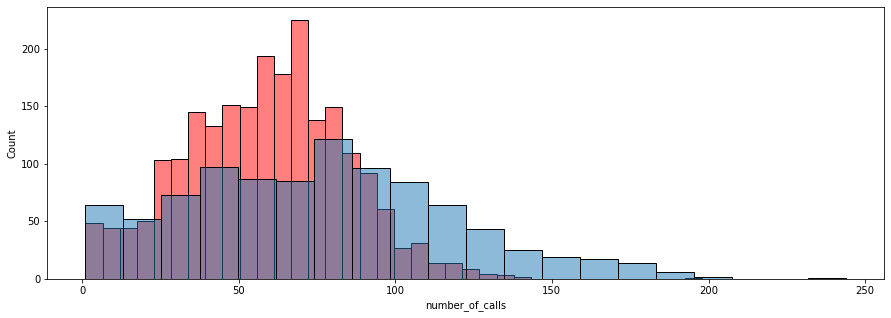

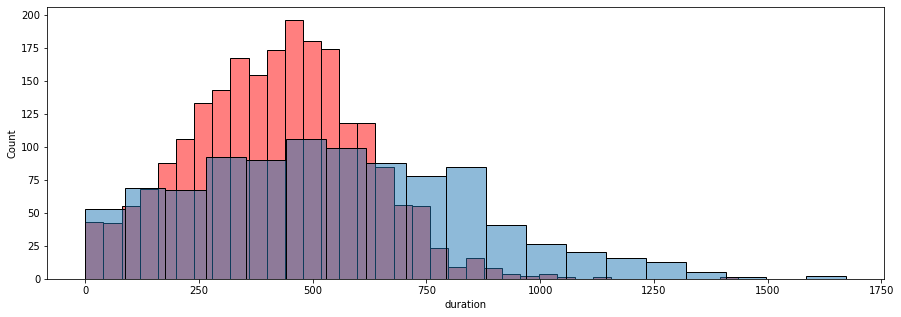

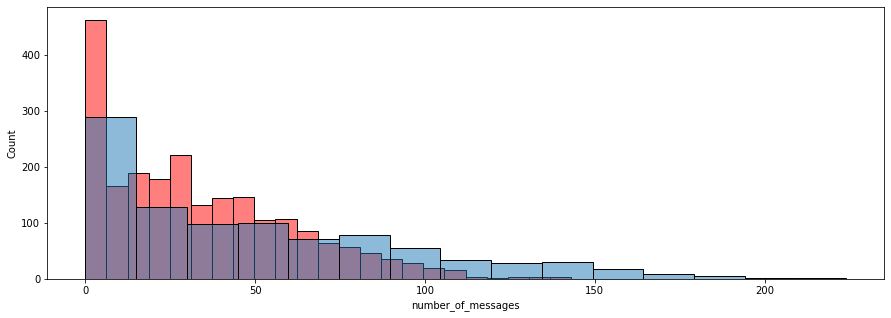

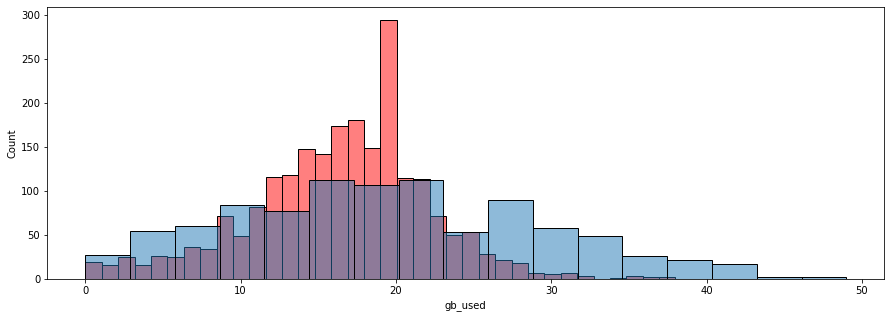

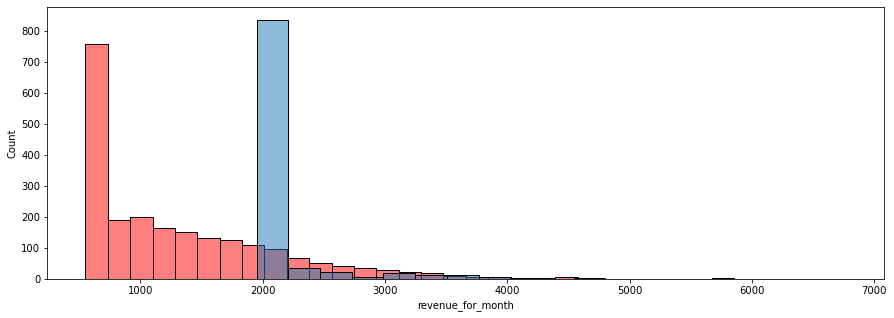

In [87]:
plot_hist_sns(calc_smart, calc_ultra)

Выведем основные статистические характеристики:

In [88]:
calc_smart.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,2223.0,1245.904184,145.837842,1001.0,1121.0,1239.0,1376.0,1499.0
month,2223.0,8.344130,2.922009,1.0,6.0,9.0,11.0,12.0
number_of_calls,2223.0,58.621233,25.796101,1.0,40.0,60.0,76.0,198.0
duration,2223.0,419.062978,189.325618,0.0,285.0,423.0,545.5,1435.0
number_of_messages,2223.0,33.396311,28.259437,0.0,10.0,28.0,51.0,143.0
gb_used,2223.0,16.329735,5.752599,0.0,13.0,17.0,20.0,38.0
revenue_for_month,2223.0,1290.891138,819.119853,550.0,550.0,1030.0,1750.0,6770.0


In [89]:
calc_ultra.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,951.0,1264.766562,140.413405,1000.0,1148.0,1281.0,1381.0,1495.0
month,951.0,8.235542,2.883937,1.0,6.0,9.0,11.0,12.0
number_of_calls,951.0,76.016824,42.403348,1.0,43.0,75.0,105.0,244.0
duration,951.0,545.451104,306.925754,0.0,310.0,528.0,756.5,1673.0
number_of_messages,951.0,49.033649,46.890656,0.0,5.0,39.0,79.0,224.0
gb_used,951.0,19.487907,9.890432,0.0,12.0,19.0,27.0,49.0
revenue_for_month,951.0,2070.977918,379.423372,1950.0,1950.0,1950.0,1950.0,4800.0


#### Вывод. Распределение значений в параметрах

Первое что бросается в глаза - пользователей тарифа *ultra* почти в два раза меньше, это логично - он дороже. Практические во всех случаях распределение параметров у тарифа ultra имеет более широкий охват значений. Пользователи этого тарифа, в среднем, больше звонят, пишут сообщения и расходуют больше интернет-трафика. Это обусловлено тем, что лимиты по минутам, сообщениям и интернет-трафику у тарифа ultra превосходят лимиты тарифа smart в разы. 

Пройдемся по конкретным параметрам:

1) **Продолжительность звонка**. Вид распределений продолжительности звонков у тарифов схож, но как сказано выше - распределение продолжительности звонков пользователей тарифом ultra шире, а у тарифа smart выше пик. Причем пик распределения у тарифа smart приходится на лимит по продолжительности звонков в месяц, пользователи стараются не превысить его чтобы не переплачивать - выглядит логично. Оба распределения с положительной асимметрией. На положительную асимметрию скорее всего влияют пропущенные звонки с нулевой длительностью. 

Основные показатели занесены в таблицу:

| Тариф|Средняя продолжительность звонка, мин|Медианная продолжительность звонка, мин| Максимальная продолжительность звонка, мин |
| -----|:-----------------------------------:|:-------------------------------------:|:-------------------------------------:|
| smart| 419                                 |  423                                  | 1435
| ultra| 545                                 |  528                                  | 1673

2) **Расход интернет-трафика**. Вид распределений количества использованного трафика у обоих тарифов практически симметричные и квазинормальные. Но они отличаются по скосу, пусть и незначительно. Распределение тарифа smart имеет отрицательную асимметрию, а по тарифу ultra - положительную. Пользователям тарифа smart явно не хватает интернет трафика. В среднем они превышают тарифный лимит в 15 Гб, возможно это и является причиной отрицательной асимметрии распределения. Пики распределений практически совпадают. 

Основные показатели занесены в таблицу:

| Тариф        |  Среднее количество израсходованного трафика, Гб   | Медианное количество израсходованного трафика, Гб | Максимальное количество израсходованного трафика, Гб |
| ------------ |:----------------------------------------:| :--------------------------------------:|:--------------------------------------:|
| smart        | 16                                       |  17                                     | 38
| ultra        | 20                                       |  19                                     | 49

3) **Число звонков**. Распределение количества звонков пользователей тарифа ultra практические симметричное, а тарифа smart имеет отрицательную асимметрию. 

Основные показатели занесены в таблицу:
 
| Тариф        |  Среднее количество звонков, шт          | Медианное количество звонков, шт        | Максимальное количество звонков, шт        |
| ------------ |:----------------------------------------:| :--------------------------------------:|  :--------------------------------------:|
| smart        | 58                                       |  76                                     | 198
| ultra        | 76                                       |  75                                     | 244

4) **Число сообщений**. Распределения имеют сильную положительную асимметрию - большинство людей мало отправляют сообщения, но есть пользователи которые активно их отправляют. В целом распределения очень похожи, однако, распределения числа сообщений пользователей тарифа ultra - распределение шире. Опять же это связано с лимитом на отправку бесплатных сообщений, у пользователей тарифом smart он составляет 50, а у пользователей тарифа ultra - 1000. Поэтому основная масса пользователей тарифа smart отправляет до 50 сообщений, чтобы не переплачивать когда лимит иссякнет.

Основные показатели занесены в таблицу:

| Тариф        |  Среднее количество сообщений, шт        | Медианное количество сообщений, шт      | Максимальное количество сообщений, шт      |
| ------------ |:----------------------------------------:| :--------------------------------------:|:--------------------------------------:|
| smart        | 39                                       |  34                                     | 143
| ultra        | 61                                       |  52                                     | 224

5) **Среднемесячная выручка**. Оба распределения имеют характерные высокие пики, которые приходятся на стоимость ежемесячной тарификации. Следует отметить, что по виду распределения можно сказать, что пользователи тарифа smart чаще переплачивают израсходовав месячный лимит по одному из параметров (например интернет-трафик, что было отмечено выше). Это подтверждает сильная положительная асимметрия у распределения среднемесячной выручки от клиентов тарифа smart. Положительная асимметрия также наблюдается у распределения для тарифа ultra, но не столь выраженная.

Основные показатели занесены в таблицу:

| Тариф        |  Средняя выручка с пользователя в месяц, руб        | Медианная выручка с пользователя в месяц, руб      | Максимальная выручка с пользователя в месяц, руб       |
| ------------ |:----------------------------------------:| :--------------------------------------:|:--------------------------------------:|
| smart        | 1291                                       |  1030                                   | 6770
| ultra        | 2070                                      |  1950                                    | 4800



### Распределение средних значений в течении года

Интересно посмотреть как все параметры, в сренем, меняются в течении года. 

Приведем средние значения параметров по месяцам в зависимости от тарифа в сводную таблицу:

In [90]:
mean_values_on_month = calc.pivot_table(index=['month', 'tariff'], values=['duration', 
                                                    'gb_used', 
                                                    'number_of_calls', 
                                                    'number_of_messages',
                                                    'revenue_for_month'])

Уберем возникший в результате группировки мультииндекс:

In [91]:
mean_values_on_month.reset_index(level=1, inplace=True)
mean_values_on_month.reset_index(inplace=True)

In [92]:
mean_values_on_month

,month,tariff,duration,gb_used,number_of_calls,number_of_messages,revenue_for_month
0,1,smart,203.852941,8.735294,27.676471,18.235294,721.323529
1,1,ultra,428.111111,13.222222,59.444444,33.777778,1950.000000
2,2,smart,298.689655,11.844828,40.189655,24.086207,827.603448
3,2,ultra,297.125000,12.000000,41.541667,21.958333,1975.000000
4,3,smart,390.051948,15.233766,54.324675,31.857143,1164.623377
5,3,ultra,489.648649,17.648649,67.675676,32.297297,2014.864865
6,4,smart,367.133929,13.625000,51.312500,30.741071,963.089286
7,4,ultra,475.301887,17.528302,66.509434,32.584906,2003.773585
8,5,smart,387.361702,15.907801,55.241135,33.773050,1197.510638
9,5,ultra,534.250000,19.671875,75.906250,37.859375,2064.843750


Разделим пользователей с разными тарифами по двум датафреймам:

In [93]:
mean_values_on_month_smart = mean_values_on_month.query('tariff == "smart"')
mean_values_on_month_ultra = mean_values_on_month.query('tariff == "ultra"')

После разделения датафрейма столбец *tariff* больше не нужен.

In [94]:
mean_values_on_month_smart = mean_values_on_month_smart.drop(['tariff'], axis=1)
mean_values_on_month_ultra = mean_values_on_month_ultra.drop(['tariff'], axis=1)

Построим графики изменения средних значений параметров в зависимости от месяца:

In [95]:
def plot_bar(df_1, df_2):
    columns = df_1.columns    
    for column in columns:
        if column != 'month':
            ax = df_1.plot(
            marker = 'o',
            y=column, 
            x='month',
            label='smart', 
            figsize=(15,5),
            grid=True,
            color='red')
            df_2.plot(
            marker = 'o',
            y=column, 
            x='month',
            label='ultra', 
            figsize=(16,4), 
            ax=ax, 
            grid=True)
            ax.set_ylabel(column)
            ax.set_xlabel('month')

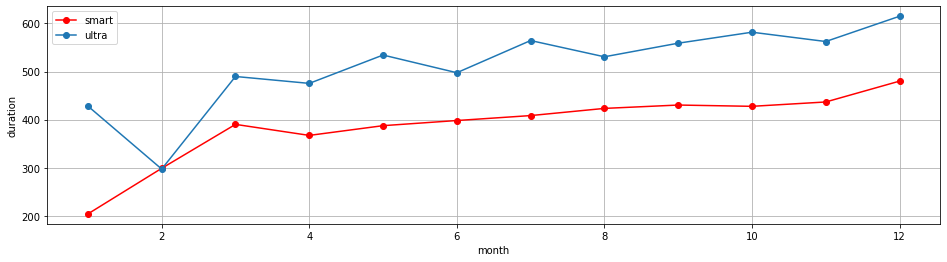

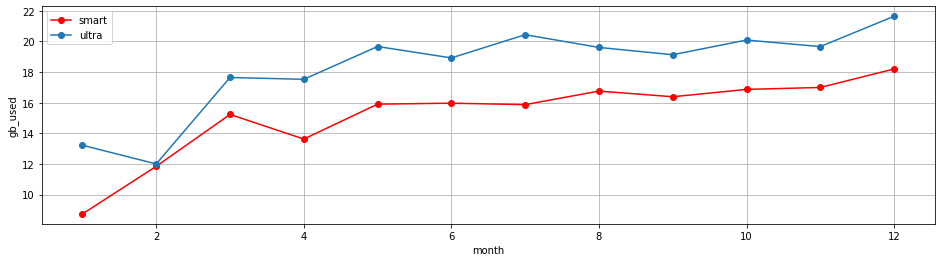

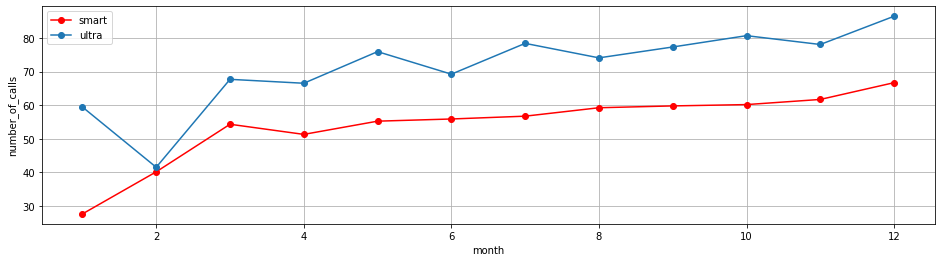

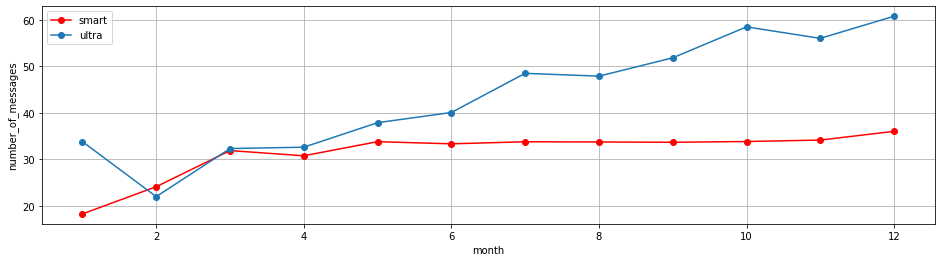

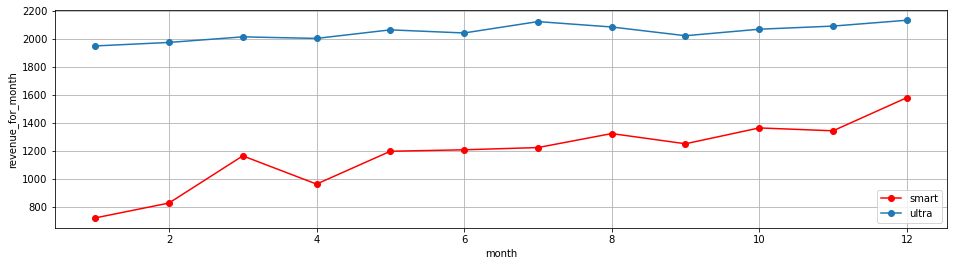

In [96]:
plot_bar(mean_values_on_month_smart, mean_values_on_month_ultra)

В целом практически все параметры растут в течении года. Примечательно, что это не относится к среднемесячной выручки от пользователей тарифа ultra. Распределение практические равномерное, это говорит о том, что пользователи реже превышают лимит установленный тарифом (отмечалось в предидущем разделе).

#### Вывод. Распределение средних значений в течении года

Все параметры, в среднем, растут в течении года, получается активность пользователей растет на протяжении года. По тарифу ultra наблюдается просадка средних значений: продолжительности звонка, числа звонков и сообщений феврале.

Разберем каждый из параметров в отдельности:

1) **Средняя продолжительность звонка**. Из графика по тарифу smart наблюдается рост средней продолжительности звонков практически в 2 раза с января по март (с 203 до 400 минут). В апреле имеем небольшую просадку (до 367 минут), затем устойчивый рост продолжительности звонков до декабря (до 479 минут). По тарифу ultra, как отмечалось выше, наблюдается снижение среднего значения продолжительности (с 428 до 297 минут). В марте средняя продолжительность звонка вырастает до 490 минут, затем на протяжении всего года наблюдается осциллирующий рост до декабря (615 минут).

2) **Средний расход интернет-трафика**. График зависимости среднего расхода интернет-трафика по тарифу smart в зависимости от месяца практически полностью повторяет зависимость средней продолжительности звонка от месяца. По тарифу ultra в феврале столь сильной просадки значений среднего интернет-трафика не наблюдается, значение остается практически на том же уровне. С февраля по декабрь потребление трафика растет с 13 до 22 Гб.

3) **Среднее число звонков**. Графики зависимости среднего числа звонков в зависимости от месяца и практически полностью повторяют зависимость от средней продолжительности звонка от месяца. 

4) **Среднее число сообщений**. Графики зависимости среднего числа сообщений в зависимости от месяца и практически полностью повторяют зависимость от средней продолжительности звонка от месяца. 

5) **Среднемесячная выручка**. Из графика по тарифу smart наблюдается рост среднемесячной выручки в течении всего года (с 721 до 1580 рублей), это связано с ростом активности пользователей в течении года, отмеченным ранее. Пользователям начинает не хватать установленных тарифом лимитов, и они вынуждены докупать минуты, гигабайты и сообщения. По тарифу smart картина совсем иная, среднемесячная выручка практически равномерно распределена в течении всего года. Однако, из-за роста пользовательской активности, растет и среднемесячная выручка, но не так значительно, как у тарифа smart (с 1950 до 2134 рубля).


### Расчет средних значений, дисперсий и стандартных отклонений

Воспользуемся датафреймами `calc_smart` и `calc_ultra` собранными в прошлом разделе. Выведем первые 5 строк каждого из них:

In [97]:
calc_smart.head()

,user_id,month,number_of_calls,duration,number_of_messages,gb_used,revenue_for_month
8,1001,11,59,430,0.0,18.0,1150.0
9,1001,12,63,414,0.0,14.0,550.0
10,1002,6,15,117,4.0,11.0,550.0
11,1002,7,26,214,11.0,18.0,1150.0
12,1002,8,42,289,13.0,20.0,1550.0


In [98]:
calc_ultra.head()

,user_id,month,number_of_calls,duration,number_of_messages,gb_used,revenue_for_month
0,1000,5,22,159,22.0,3.0,1950.0
1,1000,6,43,172,60.0,23.0,1950.0
2,1000,7,47,340,75.0,14.0,1950.0
3,1000,8,52,408,81.0,14.0,1950.0
4,1000,9,58,466,57.0,15.0,1950.0


Среднее значение, дисперсию и стандартное отклонение для каждого параметра запишем в соответствующие константы.

- Продолжительность звонка:

In [99]:
duration_stat_smart = [calc_smart['duration'].mean(), 
                       np.var(calc_smart['duration']), 
                       np.std(calc_smart['duration'])] 
duration_stat_ultra = [calc_ultra['duration'].mean(), 
                       np.var(calc_ultra['duration']), 
                       np.std(calc_ultra['duration'])] 

- Расход интернет-трафика:

In [100]:
gb_used_stat_smart = [calc_smart['gb_used'].mean(), 
                       np.var(calc_smart['gb_used']), 
                       np.std(calc_smart['gb_used'])] 
gb_used_stat_ultra = [calc_ultra['gb_used'].mean(), 
                       np.var(calc_ultra['gb_used']), 
                       np.std(calc_ultra['gb_used'])] 

- Число звонков:

In [101]:
number_of_calls_stat_smart = [calc_smart['number_of_calls'].mean(), 
                       np.var(calc_smart['number_of_calls']), 
                       np.std(calc_smart['number_of_calls'])] 
number_of_calls_stat_ultra = [calc_ultra['number_of_calls'].mean(), 
                       np.var(calc_ultra['number_of_calls']), 
                       np.std(calc_ultra['number_of_calls'])] 

- Число сообщений:

In [102]:
number_of_messages_stat_smart = [calc_smart['number_of_messages'].mean(), 
                       np.var(calc_smart['number_of_messages']), 
                       np.std(calc_smart['number_of_messages'])] 
number_of_messages_stat_ultra = [calc_ultra['number_of_messages'].mean(), 
                       np.var(calc_ultra['number_of_messages']), 
                       np.std(calc_ultra['number_of_messages'])] 

- Среднемесячная выручка:

In [103]:
revenue_for_month_stat_smart = [calc_smart['revenue_for_month'].mean(), 
                       np.var(calc_smart['revenue_for_month']), 
                       np.std(calc_smart['revenue_for_month'])] 
revenue_for_month_stat_ultra = [calc_ultra['revenue_for_month'].mean(), 
                       np.var(calc_ultra['revenue_for_month']), 
                       np.std(calc_ultra['revenue_for_month'])] 

Запишем результаты в таблицу:

In [104]:
stat_full = pd.DataFrame()
stat_full['duration_smart'] = duration_stat_smart
stat_full['duration_ultra'] = duration_stat_ultra
stat_full['gb_used_smart'] = gb_used_stat_smart
stat_full['gb_used_ultra'] = gb_used_stat_ultra
stat_full['number_of_calls_smart'] = number_of_calls_stat_smart
stat_full['number_of_calls_ultra'] = number_of_calls_stat_ultra
stat_full['number_of_messages_smart'] = number_of_messages_stat_smart
stat_full['number_of_messages_ultra'] = number_of_messages_stat_ultra
stat_full['revenue_for_month_smart'] = revenue_for_month_stat_smart
stat_full['revenue_for_month_ultra'] = revenue_for_month_stat_ultra
stat_full.index = ['Среднее значение', 'Дисперсия', 'Стандартное отклонение']

In [105]:
stat_full

,duration_smart,duration_ultra,gb_used_smart,gb_used_ultra,number_of_calls_smart,number_of_calls_ultra,number_of_messages_smart,number_of_messages_ultra,revenue_for_month_smart,revenue_for_month_ultra
Среднее значение,419.062978,545.451104,16.329735,19.487907,58.621233,76.016824,33.396311,49.033649,1290.891138,2070.977918
Дисперсия,35828.065310,94104.361174,33.077510,97.717782,665.139486,1796.153240,798.236550,2196.421581,670655.507717,143810.715601
Стандартное отклонение,189.283030,306.764341,5.751305,9.885231,25.790298,42.381048,28.253080,46.865996,818.935594,379.223833


#### Вывод. Расчет средних значений, дисперсий и стандартных отклонений

Средние значения, дисперсии и стандартные отклонения рассчитаны и записаны в датафрейм `stat_full`.

### Проверка гипотез

Заданием проекта установлены две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

#### Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Зададим критический уровень значимости равным 1 %.

In [111]:
alpha = 0.01

Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны, альтернативная - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Проверим возможность применения t-теста, выборочное среднее должно быть распределено нормально:

In [112]:
t1 = pd.Series([calc_smart['revenue_for_month'].sample(1000, replace=True).mean() for _ in range(1000)])

In [113]:
t2 = pd.Series([calc_ultra['revenue_for_month'].sample(1000, replace=True).mean() for _ in range(1000)])

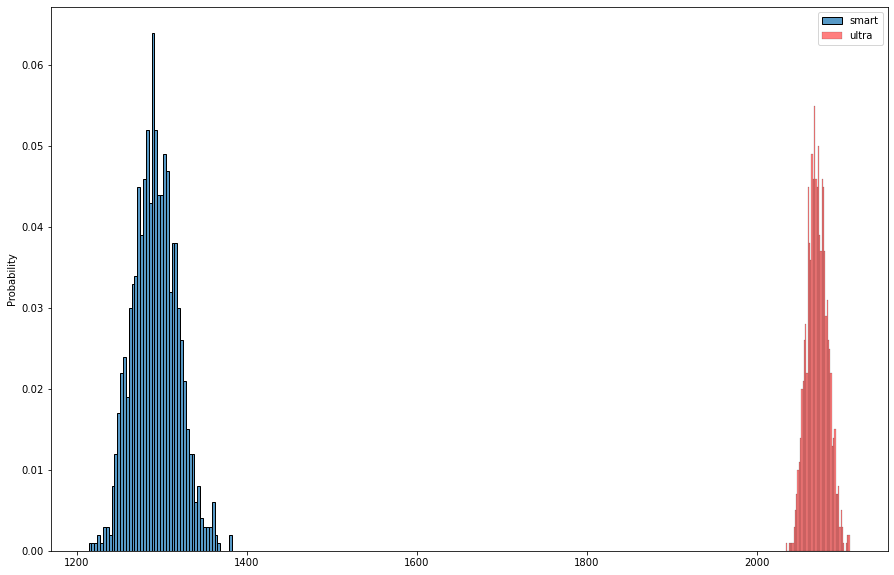

In [114]:
plt.figure(figsize=(15, 10))
sns.histplot(t1, 
             bins=50, 
             stat='probability', 
             label='smart')
sns.histplot(t2, 
             bins=50, 
             stat='probability', 
             alpha=0.5, 
             color='red',
             label='ultra')
plt.legend()
plt.show()

Построим qq график:

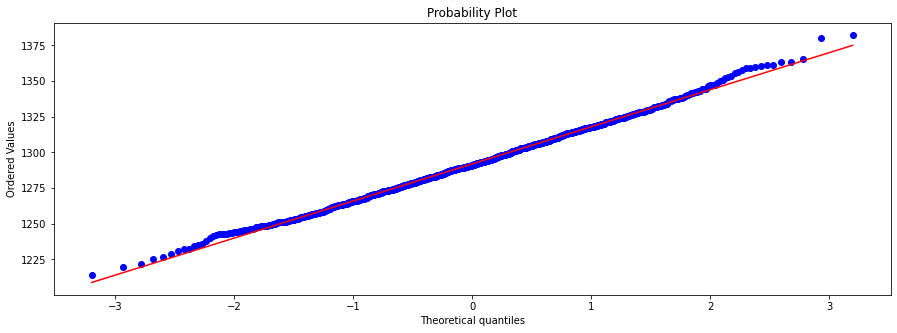

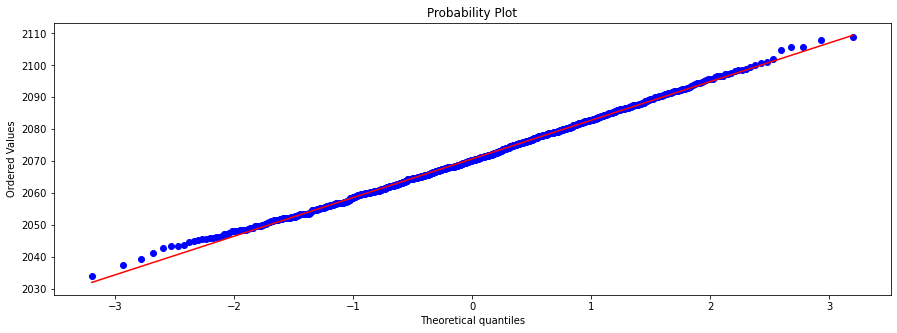

In [115]:
import pylab
plt.figure(figsize=(15, 5))
st.probplot(t1,dist='norm',plot=pylab)
plt.show()
plt.figure(figsize=(15, 5))
st.probplot(t2,dist='norm',plot=pylab)
plt.show()

Выборочные средние распределены нормально.

Проведем двусторонний t-тест:

In [116]:
results = st.ttest_ind(calc_ultra['revenue_for_month'], calc_smart['revenue_for_month'], equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.155173205867294e-245
Отвергаем нулевую гипотезу


Данные противоречат нулевой гипотезе, поэтому мы ее отбрасываем. Более того, средние выручки статистически значимо отличаются. Альтернативная гипотеза доказана - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

##### Вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

1) p-значение для нулевой гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" составляет $2.18\cdot10^{-155} $, это значение попадает в критическую область. 

2) Альтернаитвная гипотеза "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" доказана.

#### Гипотеза: cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Выведем первые 5 строк датафрейма `users`:

In [117]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Сохраним *user_id* пользователей из Москвы и пользователей из двух регионов:

In [118]:
users_from_moscow = users.query('city == "Москва"')['user_id'].to_list()
users_not_from_moscow = users.query('city != "Москва"')['user_id'].to_list()

Отфильтруем датафрейм **calc** на пользователей из Москвы и из других регионов:

In [119]:
calc_moscow = calc.query('user_id == @users_from_moscow')
calc_other_regions = calc.query('user_id == @users_not_from_moscow')

Нулевая гипотеза - средняя выручка пользователей из Москвы и из других регионов равны, альтернативная - средняя выручка пользователей из Москвы и из других регионов различаются.

Проверим возможность применения t-теста, выборочное среднее должно быть распределено нормально:

In [120]:
t1 = pd.Series([calc_moscow['revenue_for_month'].sample(1000, replace=True).mean() for _ in range(1000)])

In [121]:
t2 = pd.Series([calc_other_regions['revenue_for_month'].sample(1000, replace=True).mean() for _ in range(1000)])

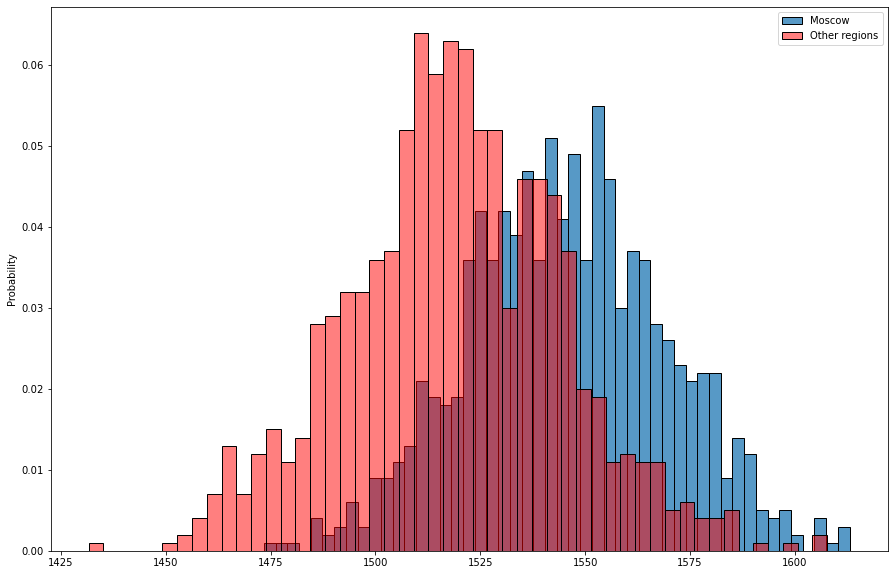

In [122]:
plt.figure(figsize=(15, 10))
sns.histplot(t1, 
             bins=50, 
             stat='probability', 
             label='Moscow')
sns.histplot(t2, 
             bins=50, 
             stat='probability', 
             alpha=0.5, 
             color='red',
             label='Other regions')
plt.legend()
plt.show()

Построим qq график:

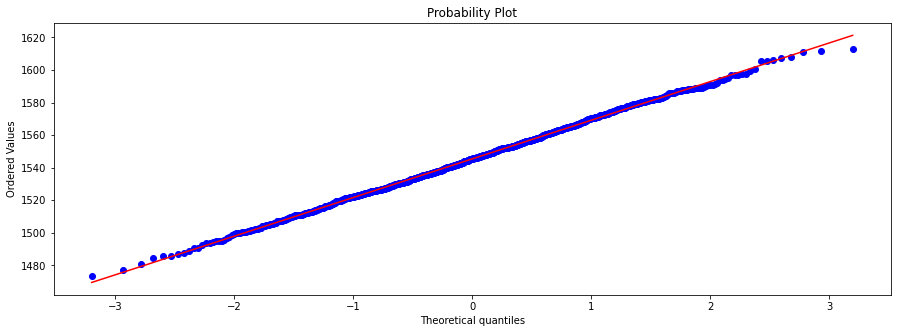

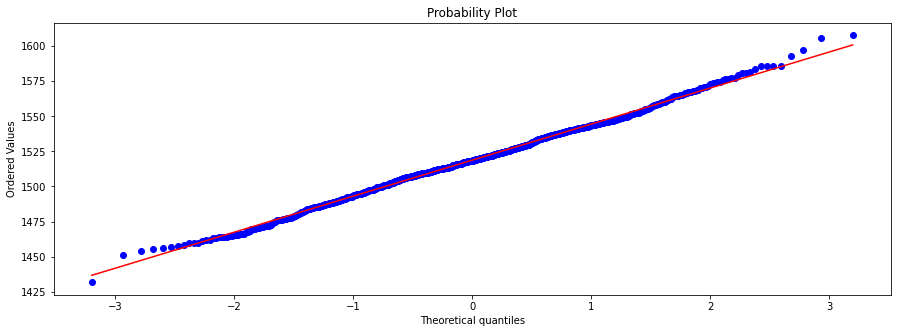

In [123]:
import pylab
plt.figure(figsize=(15, 5))
st.probplot(t1,dist='norm',plot=pylab)
plt.show()
plt.figure(figsize=(15, 5))
st.probplot(t2,dist='norm',plot=pylab)
plt.show()

Выборочные средние распределены нормально.

Проведем двусторонний t-тест:

In [124]:
results = st.ttest_ind(calc_moscow['revenue_for_month'], calc_other_regions['revenue_for_month'], equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.44113705815091153
Не получилось отвергнуть нулевую гипотезу


Данные не противоречат нулевой гипотезе, следовательно отвегнуть ее мы не можем. Выходит что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

##### Вывод: cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

1) p-значение для нулевой гипотезы "средняя выручка пользователей из Москвы и из других регионов равны" составляет 0.46, это значение не попадает в критическую область. 

2) Данные не противоречат нулевой гипотезе.

### Общий вывод

Предварительный анализ тарифов на небольшой выборке клиентов проведен. Поведение клиентов проанализировано. 

В ходе изучения общей информации о датафреймах были найдены неявные пропуски данных:

- продолжительность звонка равная нулю (доля пропусков: 20 % значений), нули несут в себе смысл, что звонок был пропущен. Такие пропуски не нуждались в обработке;
- нулевой расход интернет трафика (доля пропусков: 13 % значений), скорее всего такие неявные пропуски связаны со служебными запросами приложений и никак не связанны с реальной активностью клиентов. Поэтому во избежание искажения данных такие пропуски заполнены не были.

Из проанализированных зависимостей можно сделать вывод, что активность клиентов по всем параметрам растет в течении года и достигает пика в декабре. Стоит отметить, в связи с ростом активности в течении года пользователям тарифа "Смарт", в среднем, начинает не хватать установленных тарифом лимитов на связь. Отсюда - они, в среднем, платят больше своей ежемесячной абонентской платы практически в 3 раза. Пользователям тарифа "Ультра", в среднем, хватает установленных тарифом лимитов и их средняя выручка сходится к ежемесячной абонентской плате за тариф.

В целом из активности пользователей установленные тарифом "Ультра" лимиты кажутся очень завышенными.

В ходе работы были проверены две гипотезы:

- Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Для проверки гипотезы была выдвинута нулевая гипотеза о равенстве средней выручки тарифов "Смарт" и "Ультра" и проверена с помощью t-теста. 

Нулевая гипотеза о равенстве средней выручке по тарифам "Смарт" и "Ультра" - несостоятельна и имеет крайне низкую статистическую значимость (p-значение составляет $2.18\cdot10^{-155} $). Средняя выручка по тарифам представлена в таблице:

| Тариф|Средняя выручка, руб|
| -----|:----------------:|
|"Смарт"| 1291	|
|"Ультра"| 2071 |

- Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотезы была выдвинута нулевая гипотеза о равенстве средней выручки пользователей из Москвы и выручки пользователей других регионов и проверена с помощью t-теста.

Нулевая гипотеза о равенстве средней выручке по тарифам "Смарт" и "Ультра" - не может быть отброшена, также она имеет высокую   статистическую значимость (p-значение составляет 0.46).

В таблице представлены средние и медианные значения параметров активности пользователей:

|                                       |Тариф "Смарт"|       Тариф "Ультра"|
|---------------------------------------|:-----------:|:-------------------:|
|  Средняя продолжительность звонка, мин|419|545 |
|Медианная продолжительность звонка, мин|423 |528|
|  Среднее количество израсходованного трафика, Гб   |16|16|
|  Медианное количество израсходованного трафика, Гб   |17 | 19 |
|  Среднее количество звонков, шт          |58 |76  
|  Медианное количество звонков, шт        |76|75 |
|  Среднее количество сообщений, шт        |39|61|
| Медианное количество сообщений, шт      |34 |52  |

